In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle
from astropy.time import Time

In [2]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

In [3]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Import the ScWs from the saved file.

In [5]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2004-01-01_2024-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

Add IDs and versions together to make correctly formatted ScWs, and compute durations of the ScW observations.

In [6]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]
print(scw_list)
print(scw_durations)
print([Time(start, format='mjd').isot for start in scw_start_times])
print("Max duration in minutes:", np.max(scw_durations), "at position", np.argmax(scw_durations))

['026601100010.001', '026601110010.001', '026700000210.001', '026700000230.001', '043200640010.001', '043200650010.001', '091700010010.001', '091700020010.001', '106300180010.001', '106300190010.001', '112600220010.001', '112600230010.001', '124200010010.001', '124200020010.001', '168600570010.001', '168600580010.001', '169500010010.001', '169500020010.001', '230200070010.001', '230200080010.001', '230200090010.001', '230200160010.001', '230200170010.001', '230200180010.001', '230200470010.001', '230200480010.001', '230200490010.001', '230200550010.001', '230200560010.001', '230200570010.001', '230200570020.001', '236600410010.001', '236600420010.001', '236600440010.001', '236600450010.001', '236600460010.001', '236600470010.001', '236600480010.001', '236600490010.001', '236600500010.001', '236600510010.001', '236600520010.001', '236600530010.001', '236600540010.001', '236600550010.001', '236600560010.001', '236600570010.001', '236600580010.001', '236600590010.001', '236600600010.001',

We hardcore a catalog for Jupiter.

In [39]:
list_position = 3

# Jupiter
ra_deg = jupiter_ra[list_position]
dec_deg = jupiter_dec[list_position]

api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Jupiter"],
        [ra_deg],
        [dec_deg]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "ra",
        "dec",
    ],
    "cat_column_descr": [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["ra", "<f8"],
            ["dec", "<f8"],
    ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

Query the ODA API.

In [40]:
import json

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"RA": ra_deg,
"DEC": dec_deg,
"E1_keV": "15", # 15
"E2_keV": "30", # 30
"T_format": "mjd",
'T1': scw_start_times[list_position],
'T2': scw_end_times[list_position],
"time_bin": "60", # for light curves
"instrument": "isgri",
# "osa_version": "OSA11.2",
"product": "isgri_spectrum",
"product_type": "Real",
# "scw_list": [scw_list[list_position]],
'token': token,
'selected_catalog': json.dumps(api_cat)
}

print(par_dict)


data_collection = disp.get_product(**par_dict)
data_collection.show()

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/api.py:1069: UserWarning: 
----------------------------------------------------------------------------
the parameter: time_bin   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV']
----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2025-03-10 11:19:32), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


{'RA': 167.76038, 'DEC': 6.54112, 'E1_keV': '15', 'E2_keV': '30', 'T_format': 'mjd', 'T1': 53359.426443102, 'T2': 53359.4493713549, 'time_bin': '60', 'instrument': 'isgri', 'product': 'isgri_spectrum', 'product_type': 'Real', 'token': None, 'selected_catalog': '{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0], ["Jupiter"], [167.76038], [6.54112]], "cat_column_names": ["meta_ID", "src_names", "ra", "dec"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["ra", "<f8"], ["dec", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'}


something went quite wrong, and we think it's not likely to recover on its own: [ RequestNotUnderstood: RequestNotUnderstood():Error while setting catalog object , content of the temporary directory is [] ]
Traceback (most recent call last):
  File "/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/api.py", line 162, in func_wrapper
    return func(*args, **kwargs)
  File "/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/api.py", line 725, in poll
    self.response_json = self.request_to_json()
  File "/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/api.py", line 534, in request_to_json
    raise RequestNotUnderstood(
oda_api.api.RequestNotUnderstood: [ RequestNotUnderstood: RequestNotUnderstood():Error while setting catalog object , content of the temporary directory is [] ]
something went quite wrong, and we think it's not likely to recover on its own: [ RequestNotUnderstood: RequestNotUnderstood()

RequestNotUnderstood: [ RequestNotUnderstood: RequestNotUnderstood():Error while setting catalog object , content of the temporary directory is [] ]

IMAGE

In [43]:
data_collection.mosaic_image_0_mosaic.show()
print(data_collection.mosaic_image_0_mosaic.show_meta())

AttributeError: 'DataCollection' object has no attribute 'mosaic_image_0_mosaic'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53854.223715 from DATE-OBS.
Set MJD-END to 53854.233970 from DATE-END'. [astropy.wcs.wcs]
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/plot_tools.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


'./043200650010.001mosaic.fits'

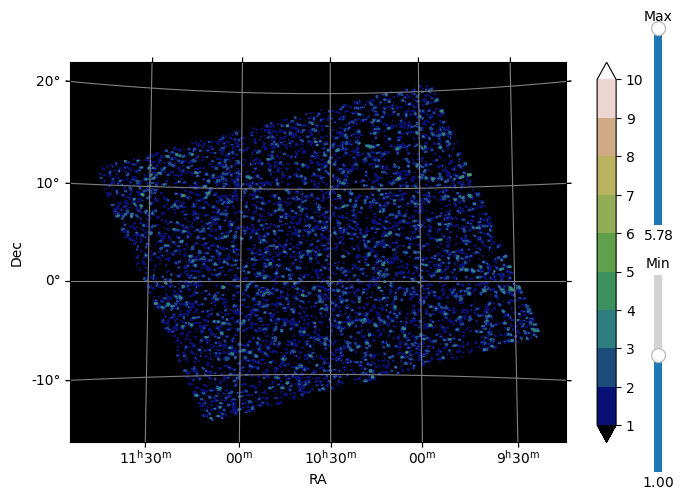

In [ ]:
im=OdaImage(data_collection)
_ = im.show()
im.write_fits(f"../data/{scw_ids[list_position]}"+f".{scw_versions[list_position]}")

Plot from the fits file.

Filename: 043200650010.001mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  GROUPING      1 BinTableHDU     82   4R x 16C   [8A, 32A, 1J, 1J, 256A, 3A, 32A, 1I, 1I, 1E, 1E, 1E, 1D, 1D, 1D, 1D]   
  2  ISGR-MOSA-IMA    1 ImageHDU        67   (507, 507)   float32   
  3  ISGR-MOSA-IMA    2 ImageHDU        67   (507, 507)   float32   
  4  ISGR-MOSA-IMA    3 ImageHDU        67   (507, 507)   float32   
  5  ISGR-MOSA-IMA    4 ImageHDU        67   (507, 507)   float32   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  507                                                  
NAXIS2  =                  507                                                  
PCOUNT  =                    0 / number o

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53854.223715 from DATE-OBS.
Set MJD-END to 53854.233970 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_1887/2354898784.py:29: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_1887/2354898784.py:29: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')


Text(-14.048868921846264, 425.00372613394063, 'Jupiter (30x Rj)')

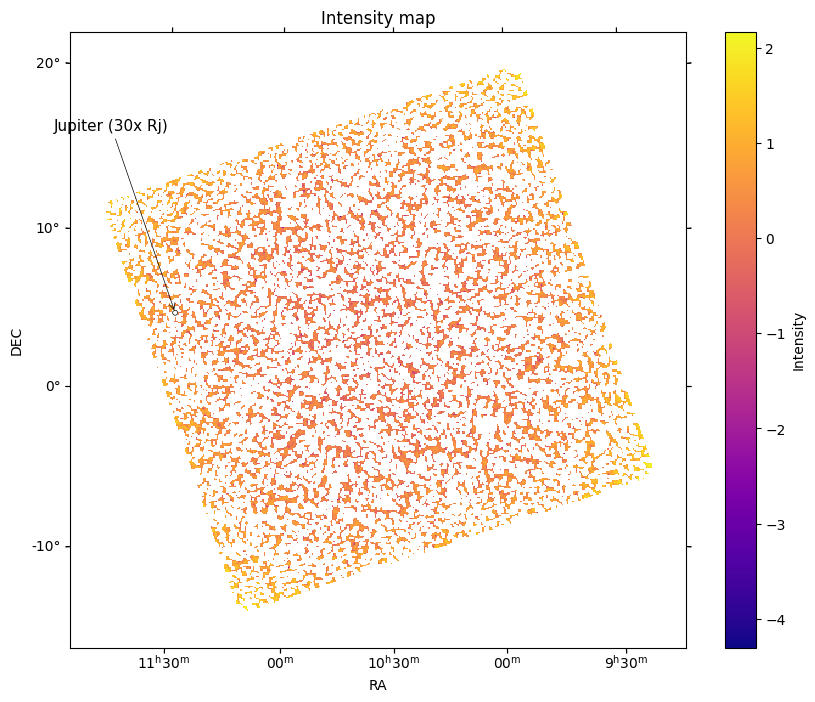

In [ ]:
fits_file = f"../data/{scw_list[list_position]}"+"mosaic.fits"

pick = 2  # 2 for image, 3 for variance, 4 for significance and 5 for exposure map

# Jupiter
ra_deg = jupiter_ra[list_position]
dec_deg = jupiter_dec[list_position]

with fits.open(fits_file) as hdul:
    hdul.info()
    intensity_data = hdul[2].data 
    variance_data = hdul[3].data
    significance_data = hdul[4].data
    exposure_data = hdul[5].data
    print("\n")
    print(repr(hdul[pick].header))
    print("\n")
    print(hdul[1].data.columns)
    wcs = WCS(hdul[pick].header)  
    CD1 = np.abs(hdul[pick].header["CD1_1"])

data = [intensity_data, variance_data, significance_data, exposure_data]
image_data = data[pick-2]

x, y = wcs.all_world2pix(ra_deg, dec_deg, 1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

pixel_scale = CD1 * 3600  # pixel size in arcseconds (|CD1_1| from fits header)
circle_radius_pixels = 30 * 40 / pixel_scale / 2  # radius in pixels (30 times Jupiter's apparent size which is ~ 40")

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw = 0.5)
ax.add_patch(circle)

title = ""
if pick == 2:
    title = "Intensity"
elif pick == 3:
    title = "Variance"
elif pick == 4:
    title = "Significance"
elif pick == 5:
    title = "Exposure"

plt.title(title+" map")
plt.colorbar(im, label="Intensity")

ax.annotate(
    text="Jupiter (30x Rj)", 
    xy=(x, y),  
    xytext=(x - 100, y + 150),
    arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
    fontsize=11,
    color="black"
)

#plt.savefig(f"../data/{scw_list[list_position]}"+"_"+f"{title}.pdf", format='pdf', bbox_inches='tight')

Let us extract the countrate and variance over time, at Jupiter's expected position.

In [1]:
x_int, y_int = int(round(x.item())), int(round(y.item()))

countrate = intensity_data[y_int, x_int]
variance = variance_data[y_int, x_int]
uncertainty = np.sqrt(variance)

print(f"x_int: {x_int}, y_int: {y_int}")
print(f"Countrate: {countrate}")
print(f"Variance: {variance}")
print(f"Uncertainty: {uncertainty}")


NameError: name 'x' is not defined